In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 

(CVXPY) Apr 11 10:52:03 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 10:52:03 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Defining code to test metrics
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))

In [3]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 1) #downsizing image
height,width = X.shape #getting height and width of image

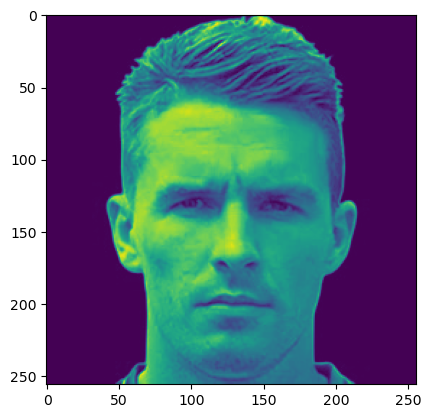

In [4]:
plt.imshow(X)

In [5]:
Y = np.fft.fft2(X) #Taking Fourier Transform

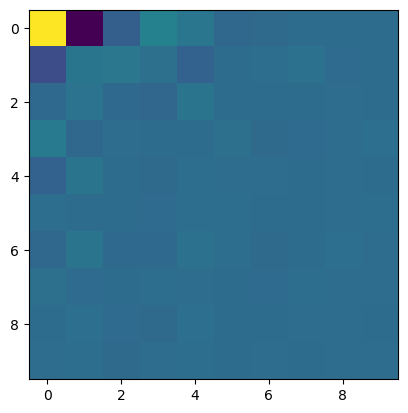

In [6]:
plt.imshow(Y[:10, :10].real)

In [7]:
width, height = Y.shape
Y.shape

(256, 256)

In [8]:
# Take the corner of size n from fourier tranfrom
n = 20
yul = Y[:n, :n]
yur = Y[:n, -n:]
yll = Y[-n:, :n]
ylr = Y[-n:, -n:]

Z = np.block([[yul, yur],
              [yll, ylr]])    
Z.shape

(40, 40)

In [9]:
z = Z.flatten()
z = z.reshape((-1, 1))
z.shape

(1600, 1)

In [10]:
# Generating matrix of 1 and 0
A = np.random.randint(0,2,size=((4*n**2),4*n**2))
A.shape

(1600, 1600)

In [11]:
b = A@z

In [12]:
error_threshold = 1e-8
# Optimization on real part
w_real = cvx.Variable(4*n**2)
w_real = w_real.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(w_real, 1))
constraints = [cvx.norm(A@w_real - b.real,2) <= error_threshold]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [13]:
# Optimization on imaginary part
w_image = cvx.Variable(4*n**2)
w_image = w_image.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(w_image, 1))
constraints = [cvx.norm(A@w_image - b.imag,2) <= error_threshold]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [14]:
w_sparse = w_real.value + w_image.value*1j #Joining up parts to make a whole iamge

In [15]:
np.count_nonzero(w_sparse.real.round(8))

1600

In [16]:
W = w_sparse.reshape((2*n,2*n))
W.shape

(40, 40)

In [17]:
Y_hat = np.zeros(width*height)
Y_hat = Y_hat.reshape((width,height))
Y_hat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
#Creating sparse matrix where the reconstructed image is just the corners of the optimizated result
Y_hat[:n, :n] = W[:n, :n] #upper left
Y_hat[:n, -n:] = W[:n, -n:] #upper right
Y_hat[-n:, :n] = W[-n:, :n] #lower left
Y_hat[-n:, -n:] = W[-n:, -n:] #lower right


/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_8557/24046794.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[:n, :n] = W[:n, :n] #upper left
/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_8557/24046794.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[:n, -n:] = W[:n, -n:] #upper right
/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_8557/24046794.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[-n:, :n] = W[-n:, :n] #lower left
/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_8557/24046794.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[-n:, -n:] = W[-n:, -n:] #lower right


In [19]:
#Reconstructing Image
X_hat = np.fft.ifft2(Y_hat).real

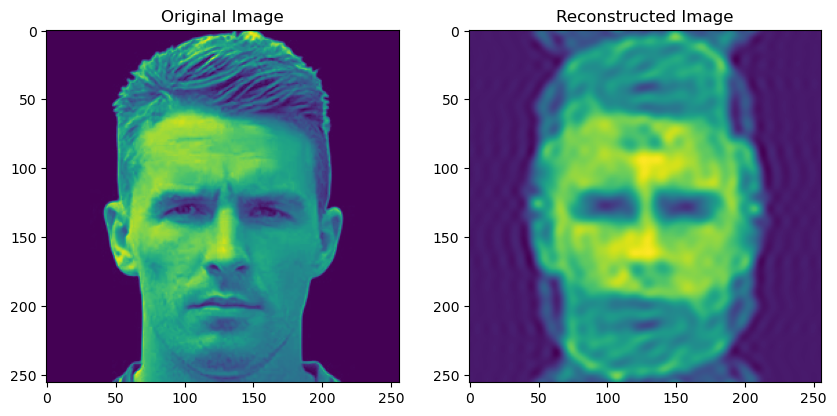

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(X_hat)
plt.title('Reconstructed Image')

plt.show()

In [21]:
norm_orig = X/255
norm_result = X_hat/255
print(mse(norm_orig, norm_result))
print(mse(X,X_hat))
print(mad(X, X_hat))

0.014372899055642699
934.5977610931664
20.0571915483247
